In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools #used to generate subsets
import networkx as nx #easy to check for connectivity
from scipy.ndimage import gaussian_filter
from skimage.segmentation import watershed
from skimage.future.graph import RAG
from sknetwork.path import distance
from skimage import util

# import sknetwork as skn
# from scipy import sparse


In [3]:
#get image and define the image space
image = plt.imread('images/dna-images/gnf/dna-0.png')[...,0]
image_range = np.array([[i,j]for i in range(image.shape[0]) for j in range(image.shape[1])])

In [ ]:
#To be removed
'''
def B_delta(p,delta): #rename suggestion: delta ball
    B = np.empty_like([p])
    for q in image_range:
        if sum(abs(p-q)) <= delta:
            B = np.append(B,[q],axis=0)
    return B
'''

## Algorithm I

### TODO

- Alg I takes too long for graph > 10 nodes. Suggestions:
    - remove all subgraphs that were already added to the list : DONE
    - problem traced back to GenerateConnectedSubgraphs. 
        - Is there a more efficent way than itertools?
        - nx.is_connected takes very long.

In [4]:
def generate_connected_subgraphs(G):
    dim = nx.number_of_nodes(G)
    vertices = range(dim)
    S = []
        
    for length in range(1,dim+1):
        for subs in list(itertools.combinations(vertices, length)):
            H = nx.induced_subgraph(G, subs)
            if len(subs) == 1:
                S.append(H)
            elif nx.is_connected(H):
                S.append(H)
    return S

In [16]:
def generate_fragments(img,std_dev,int_threshold,min_seed_dist,max_search_depth,max_frag_dist):
    #smooth image with gausian filter
    g = gaussian_filter(img,std_dev)
    #create empty copy of g to fill watersheed markers
    g_markers = np.zeros_like(g)
    #create empty copy of g to check for localmax
    g_checked = np.copy(g)
    
    #Fehlerabfangen
    
    if std_dev < 0:
        raise ValueError("smoothing strength needs to be positive")
    if int_threshold > 1 or int_threshold < 0:
        raise ValueError("relative intensity threshold needs to be between 0 and 1")
    if min_seed_dist < 1:
        raise ValueError("min seed distance needs to be >= 1")
    if max_search_depth < 0:
        raise ValueError("maximum search error needs to be positive")
    if max_frag_dist < 0:
        raise ValueError("maximum fragments distance needs zo be positive")
        
    #Create array of watershed seeds
    PI = []
    #Loop while there are still unchecked regions
    while np.amax(g_checked) != 0:
        #Get indicies of g where g is maximal
        glob_max = np.argwhere(g_checked == g_checked.max())
        #Loop over all maximum points
        for p in glob_max:
            #Set boundaries for the local ball B
            upper_bound = [max(0,p[0]-min_seed_dist),max(0,p[1]-min_seed_dist)]
            lower_bound = [min(p[0]+min_seed_dist+1,g.shape[0]),min(p[1]+min_seed_dist+1,g.shape[1])]
            #Create set with local points around p
            B = g[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]]
            #Check if p is strong local maximum
            if (g[tuple(p)] == np.amax(B) and (1-int_threshold)*g[tuple(p)] >= np.amin(B)): 
                #add p to the set of seeds
                PI.append(p)
                #Set label of the seed
                g_markers[tuple(p)] = len(PI)
            #Set the Area B = 0
            g_checked[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]] = 0
    
    #Create array of watershed regions
    Omega = []
    #Create Watershed regions
    Labels = watershed(util.invert(g),markers=g_markers)
    #loop over all labels
    for label in range(1,len(PI)+1):
        #Create array of the indices of this label
        w = np.argwhere(Labels==label) 
        #Add the array of indices to Omega
        Omega.append(w)
    
    #Create connectivity matrix
    Epsilon = RAG(Labels,connectivity=2)
    
    '''
    #Loop over number of all regions except the last
    for i in range(len(Omega)-1):
        #Loop over number of not used regions
        for j in range(i+1, len(Omega)):
            #local intensity peaks r(w)??
            if not sum(abs(PI[i] - PI[j])) <= max_frag_dist:
                Epsilon[i,j] = 0
                Epsilon[j,i] = 0   
    '''
    S = []
    subgraphs_set = generate_connected_subgraphs(Epsilon)
    #iterate over all graph vertices
    for H in subgraphs_set:
        if v in nx.nodes(H):
            if max(nx.single_source_shortest_path_length(H, v).values()) <= max_search_depth:
                Nodes = tuple([w for w in nx.nodes(H)])
                S.add(Nodes)
                break
    S = [set(x) for x in S]

    return Omega,Labels,S

###  Test: Algorithm I

In [ ]:
adjacency = np.array([[0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [0, 1, 0, 0]])
G = nx.Graph(adjacency)
nx.draw(G)

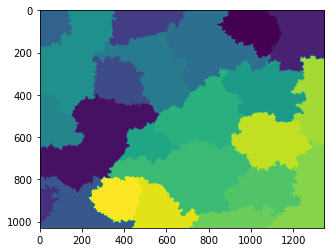

In [28]:
#testing ALg I
a,b,c = generate_fragments(image,1,0.1,150,1,1)
plt.imshow(b)
plt.show()

#to use when c = Epsilon
#nx.draw(c)
#nx.number_of_nodes(c)
print(c)
#won't print c, idk why

In [15]:
adjacency = np.array([[0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [0, 1, 0, 0]])
G = nx.Graph(adjacency)
S = set()
subgraphs_set = generate_connected_subgraphs(G)
#iterate over all graph vertices
for H in subgraphs_set:
    #find all subgraphs that have i as a node
    for v in nx.nodes(H):
        if max(nx.single_source_shortest_path_length(H, v).values()) <= 3:
            Nodes = tuple([w for w in nx.nodes(H)])
            S.add(Nodes)
            break 
S = [set(x) for x in S]
S

[{0, 1},
 {1, 3},
 {2},
 {1, 2},
 {0, 1, 2},
 {0, 1, 3},
 {1, 2, 3},
 {1},
 {0, 2},
 {0, 1, 2, 3},
 {0},
 {3}]

### Algorithm II

In [ ]:
def global_solution(f,alpha,Omega,S):
    #Set Variables we dont need Z but f_used
    n = len(S) 
    u = np.zeros(n)
    V = Omega
    f_used = np.copy(f)
    #First Loop over copy of Omega
    while V != 0:
        c = np.empty(n)
        #Loop over number of Subgraphs in S
        for k in range(n):
            #Set intersection length
            Zk_V = len(np.intersect1d(Omega,np.array(list(S[k]))))
            #Set c if intersection is non empty 
            if  Zk_V !=0:
                c[k] = (f[k] + alpha) / Zk_V
            #Else set it to nan to ignore it
            else:
                c[k] = np.nan
        #Get the argmin of c
        k_min = np.nanargmin(c)
        #Set u of argmin to 1
        u[k_min] = 1 
        #Loop over all areas in Z_k
        for w in S[k]:
            #Set V of those areas to 0 to indicate that they have been used already
            V[V==w] = 0
    
    #Second loop over not used elements of f
    while f_used != np.empty(n):
        #Set current element of interest k_prim
        k_prim = np.nanargmin(f_used)
        #check if u[_k_prim hasn been used in first loop
        if u[k_prim]==0:
            #crate subvector v of u
            v = np.copy(u)
            #loop over all elements of u that are non zero
            for ind in np.nonzero(u):
                #check if Z_ind is subset of Z_kprim
                if S[ind] not in S[k_prim]:
                    #if not set v to 0 to ignore it in the union
                    v[ind] = 0
            #check if union of all left subsets is equal Z_kprim
            if S[k_prim] == set().union(S[k] for k in np.nonzero(v)):
                #check smth...
                if f[k_prim]+alpha < np.dot(v,f + (alpha*np.ones(n))):
                    #Set u values of the used subsets to 0 and the union to 1
                    u = u-v
                    u[k_prim] = 1
        #make f equal to nan for the used region
        f_used[k_prim]=np.nan
    return u